In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split


def create_artificial_records(dataset, num_artificial_records=10000):
    artificial_records = []
    
    # Separate diabetic and non_diabetic
    diabetic = dataset[dataset[:, -1] == 1]
    non_diabetic = dataset[dataset[:, -1] == 0]
    
    for partition in [diabetic, non_diabetic]:
        # partition by age
        young = partition[partition[:, -2] < 40]
        old = partition[partition[:, -2] >= 40]
        
        for age_group in [young, old]:
            # separate pregnant and non_pregnat
            pregnant = age_group[age_group[:, 0] > 0]
            non_pregnant = age_group[age_group[:, 0] == 0]
            
            for group in [pregnant, non_pregnant]:
                if len(group) > 0:  # make sure non_empty
                    for _ in range(num_artificial_records // 4):
                        new_record = group[np.random.randint(len(group))].copy()
                        
                        # change slightly on glucose and insulin
                        glucose_change = np.random.uniform(-10, 10)
                        new_record[1] += glucose_change
                        new_record[4] -= glucose_change * 0.5
                        
                        # change slightly on skin_change and BMI
                        skin_change = np.random.uniform(-5, 5)
                        new_record[3] += skin_change
                        new_record[5] += skin_change * 0.1
                        
                        artificial_records.append(new_record)
    
    return np.array(artificial_records)





# 设置随机种子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# 加载数据集
dataset = pd.read_csv("diabetes_dataset_1.csv")
#dataset = dataset[['age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level','diabetes']]

cols_to_replace = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_to_replace:
    dataset[col] = dataset[col].replace(0, np.nan)
    dataset[col].fillna(dataset[col].median(), inplace=True)

# 数据集归一化
normalized = preprocessing.normalize(dataset, norm='max', axis=0, copy=True)

# 创建人工记录
artificial_dataset = create_artificial_records(normalized)
print(artificial_dataset.shape)
# 合并原始数据集和人工数据集
combined_dataset = np.vstack((normalized, artificial_dataset))

print(combined_dataset.shape)

X = combined_dataset[:, 0:-1]
Y = combined_dataset[:, -1]

# 转换为PyTorch张量
X = torch.FloatTensor(X).unsqueeze(2)
Y = torch.FloatTensor(Y)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)


# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(1, 32, batch_first=True)
        self.lstm2 = nn.LSTM(32, 64, batch_first=True)
        self.lstm3 = nn.LSTM(64, 128, batch_first=True)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

# 初始化模型、损失函数和优化器
model = LSTMModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())  # 使用Adam优化器替代NAdam

num_epochs = 300 # 可能需要增加训练轮数

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == batch_y).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            test_correct += (predicted == batch_y).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(test_dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

C:\Users\Bxdjc\AppData\Local\Temp\ipykernel_11376\316968623.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].median(), inplace=True)
C:\Users\Bxdjc\AppData\Local\Temp\ipykernel_11376\316968623.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


(10000, 9)
(10768, 9)
Epoch [1/300], Train Loss: 0.6944, Train Acc: 0.4967, Test Loss: 0.6930, Test Acc: 0.5037
Epoch [2/300], Train Loss: 0.6932, Train Acc: 0.5080, Test Loss: 0.6928, Test Acc: 0.5037
Epoch [3/300], Train Loss: 0.6931, Train Acc: 0.5029, Test Loss: 0.6926, Test Acc: 0.5149
Epoch [4/300], Train Loss: 0.6927, Train Acc: 0.5106, Test Loss: 0.6924, Test Acc: 0.5037
Epoch [5/300], Train Loss: 0.6924, Train Acc: 0.5103, Test Loss: 0.6911, Test Acc: 0.5441
Epoch [6/300], Train Loss: 0.6914, Train Acc: 0.5195, Test Loss: 0.6903, Test Acc: 0.5747
Epoch [7/300], Train Loss: 0.6886, Train Acc: 0.5365, Test Loss: 0.6830, Test Acc: 0.5729
Epoch [8/300], Train Loss: 0.6576, Train Acc: 0.6238, Test Loss: 0.6550, Test Acc: 0.6123
Epoch [9/300], Train Loss: 0.6330, Train Acc: 0.6535, Test Loss: 0.6191, Test Acc: 0.6681
Epoch [10/300], Train Loss: 0.6236, Train Acc: 0.6639, Test Loss: 0.6231, Test Acc: 0.6657
Epoch [11/300], Train Loss: 0.6209, Train Acc: 0.6645, Test Loss: 0.6325, Tes

val_accuracy =  0.881


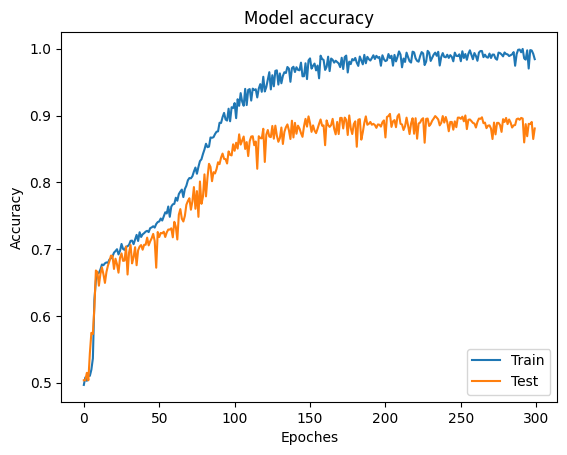

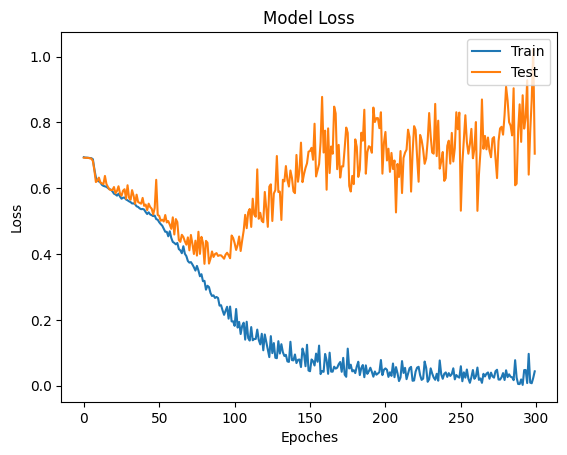

AUC: 0.987


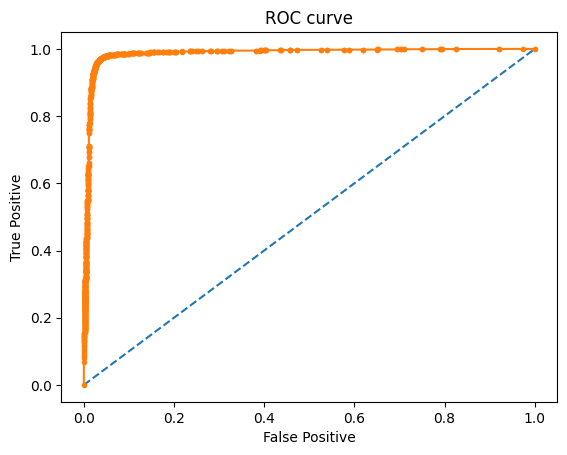

In [3]:
print('val_accuracy =  %.3f' % test_accuracies[-1])

# 绘制精度图
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoches')
plt.legend(loc='lower right')
plt.savefig('accuracy.png')
plt.show()

# 绘制损失图
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.legend(loc='upper right')
plt.savefig('loss.png')
plt.show()

# 保存模型
torch.save(model.state_dict(), 'pima_indian.pth')

# 绘制ROC曲线
model.eval()
with torch.no_grad():
    probs = model(X).squeeze().numpy()
auc = roc_auc_score(Y, probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(Y, probs)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('ROC curve')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.savefig('roc.png')
plt.show()
